
# Predicting Student Success Using Supervised Machine Learning: Evidence from the Open University Learning Analytics Dataset
*final project for Introduction to Machine Learning: Supervised Learning*

*Author*: Yun Xia  
*Date*: Oct 2025  
*Email*: yuxi8959@colorado.edu  
*Course*: Introduction to Machine Learning: Supervised Learning     

# 1. Project Topic
In this final project, I tackle a practical question using the Open University Learning Analytics (OULAD) data:
1) Multi-class classification: I predict each student's final outcome — Pass, Fail, Withdrawn, or Distinction — from demographics, registration timing, VLE engagement (clicks), and assessment-related signals without leaking labels.

I combine simple, interpretable baselines (Logistic Regression; KNN) with robust tree models (SVM, adaBoost and Random Forest). 
My goals are to flag at-risk students early and to forecast performance so instructors can offer timely, personalized, and fair support in online learning environments.




# 2. Dataset description

## Source and collection
I use the Open University Learning Analytics Dataset (OULAD), a public dataset derived from the Open University’s Virtual Learning Environment (VLE) logs and student information systems. It combines de-identified demographics (age band, IMD band, region, gender, disability), registration timelines (date of registration/unregistration), interaction logs with online learning materials (studentVle → aggregated `sum_click`), and assessment records (studentAssessment joined with assessments → `avg_assessment_score`). Records are linked via student identifiers and course keys (`code_module`, `code_presentation`).

## Public availability
OULAD is openly available for research and teaching. For convenience, I access a mirrored copy on Kaggle that hosts the same tables as the original release.
Kaggle mirror: https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad

Citations of the dataset in APA format 
```text 
Kuzilek, J., Hlosta, M., & Zdrahal, Z. (2017). 
Open university learning analytics dataset. Scientific data, 4(1), 1-8.
```
DOI Link: https://doi.org/10.1038/sdata.2017.171  

## Scope in this project
the dataset contains seven modules (courses) across multiple presentations (J, B) from 2013 to 2016, totaling tens of thousands of student–module records. The key tables are:
- `assessments.csv`: Details of assessments (e.g., exams, assignments) for each module.
- `studentAssessment.csv`: Scores obtained by students in each assessment.
- `studentRegistration.csv`: Records of student registration dates and withdrawal status.
- `vle.csv`: Information about Virtual Learning Environment (VLE) activities.
- `studentVle.csv`: Logs of student interactions with the VLE.
- `courses.csv`: Metadata about courses/modules.
- `studentInfo.csv`: Demographic and outcome information for each student.

I build a single analysis table by merging: studentInfo + studentRegistration + aggregated studentVle clicks + aggregated studentAssessment scores. This covers seven modules across multiple J/B presentations, totaling on the order of tens of thousands of student–module records.

## File size and dataset inspection
The file size of the dataset is shown below.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

# set kaggle environment flag
KAGGLE_ENV = False
WITH_SVM = False
base_path = "/kaggle/input/open-university-learning-analytics" if KAGGLE_ENV else "./dataset"

for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"File: {filename}, Size: {file_size_mb:.2f} MB")

File: studentAssessment.csv, Size: 5.43 MB
File: studentInfo.csv, Size: 3.30 MB
File: studentVle.csv, Size: 432.81 MB
File: courses.csv, Size: 0.00 MB
File: vle.csv, Size: 0.25 MB
File: studentRegistration.csv, Size: 1.06 MB
File: assessments.csv, Size: 0.01 MB



# 3. Data Merging and Cleaning
I analyze the following tables from the OULAD dataset, I plan to merge them into a single DataFrame for modeling:
1. Merge studentInfo with studentRegistration on student and course identifiers.
2. Aggregate VLE clicks and merge with the main DataFrame.
3. Aggregate assessment scores and merge with the main DataFrame.  

## student info 

In [2]:
# Our main classification target (Pass/Fail/Withdrawn/Distinction)
TARGET_COL = "final_result"  
# Demographics + final outcomes
student_info = pd.read_csv(f"{base_path}/studentInfo.csv")          
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass



Here are my description of columns in studentInfo.csv:
- `code_module`: The module (course) code (e.g., AAA, BBB). Categorical, one-hot encode.
- `code_presentation`: The presentation (semester) code (e.g., 2013J, 2014B). Categorical, one-hot encode.
- `id_student`: Unique identifier for each student. Identifier, drop as it does not contribute to prediction.
- `gender`: Gender of the student (e.g., Male, Female). Binary, label encode.
- `region`: Geographic region of the student. There are 13 unique values, so it can be Categorical, one-hot encode.
- `highest_education`: Highest education level achieved by the student. There are 5 unique values, so it can be Categorical, one-hot encode.
- `imd_band`: Index of Multiple Deprivation (socioeconomic status). Ordinal, encode as numerical scale (0-9).
- `age_band`: Age group of the student (e.g., 0-35, 35-55, 55+). Ordinal, encode as numerical scale (0-2).
- `num_of_prev_attempts`: Number of previous attempts at the module. Numeric, keep as is.
- `studied_credits`: Number of credits the student is studying. Numeric, keep as is.
- `disability`: Whether the student has declared a disability (e.g., Y, N). Binary, label encode.
- `final_result`: The final outcome of the student (Pass, Fail, Withdrawn, Distinction). Target variable, label encode.

Decision:
- Drop `id_student` as it is an identifier.
- One-hot encode `code_module`, `code_presentation`, `region`, and `highest_education`.
- Label encode `gender` and `disability`.
- Ordinal encode `imd_band` and `age_band`.
- Keep `num_of_prev_attempts` and `studied_credits` as numeric features.
- Label encode `final_result` as the target variable.


## Assessments and student Assessments

In [3]:
# Assessment metadata (weights, types)
assessments = pd.read_csv(f"{base_path}/assessments.csv")
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0



Here are my description of columns in assessments.csv:
- `code_module`: The module (course) code. Identifier for joining with other tables.
- `code_presentation`: The presentation (semester) code. Identifier for joining with other tables.
- `id_assessment`: Unique identifier for each assessment. Primary key.
- `assessment_type`: Type of assessment (e.g., TMA, CMA, Exam). Categorical variable.
- `date`: Due date of the assessment (days from module start). Numeric, can be used to understand timing.
- `weight`: Weight of the assessment in the final grade (e.g., 10%, 40%). Numeric, crucial for calculating weighted scores.

Decision:
- This table will be joined with studentAssessment to enrich score records with assessment metadata.
- The `weight` column is essential for calculating weighted average scores.
- After joining and aggregation, this table won't contribute direct features; instead it helps compute `avg_assessment_score`.

In [4]:
# Individual assessment scores
student_assessment = pd.read_csv(f"{base_path}/studentAssessment.csv")
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0



Here are my description of columns in studentAssessment.csv:
- `id_assessment`: Links to the assessment identifier in assessments.csv. Foreign key.
- `id_student`: Links to the student identifier. Foreign key.
- `date_submitted`: When the student submitted the assessment (days from module start). Numeric.
- `is_banked`: Whether the assessment result was banked from a previous presentation. Binary (0/1).
- `score`: The score achieved by the student (0-100). Numeric, our key performance metric.

Decision:
- Join with assessments to get weights for each score.
- Aggregate `score` (weighted by assessment weights) per student to create `avg_assessment_score` feature.
- Individual assessment records won't be kept; only the aggregated weighted average will be merged into the main dataset.


**Note on assessment weights:**
Each assessment has a different weight (e.g., final exam = 40%, quiz = 10%). When calculating a student's average score, we should use weighted average instead of simple mean. Otherwise, a small quiz would count as much as the final exam, which doesn't reflect the real grading scheme.


## student Registration 

In [5]:
# Registration/withdrawal dates
student_registration = pd.read_csv(f"{base_path}/studentRegistration.csv")
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN



Here are my description of columns in studentRegistration.csv:
- `code_module`: The module (course) code. Identifier for joining.
- `code_presentation`: The presentation (semester) code. Identifier for joining.
- `id_student`: Unique student identifier. Identifier for joining.
- `date_registration`: Day when the student registered (relative to module start). Numeric, indicates early/late registration.
- `date_unregistration`: Day when the student unregistered (if they withdrew). Numeric with ~70% missing (students who didn't withdraw).

Decision:
- Merge with main dataset on student and course identifiers.
- Keep `date_registration` as a numeric feature (impute missing with median).
- **Drop `date_unregistration`**: This feature creates data leakage! Students who withdrew have non-null `date_unregistration`, which directly reveals that their `final_result='Withdrawn'`. Using this would be cheating - the model would just learn "if date_unregistration exists, predict Withdrawn". For fair prediction, I must exclude this feature.


## 3.4 VLE activity metadata 

In [6]:
# VLE activity metadata (not used directly)
vle = pd.read_csv(f"{base_path}/vle.csv")
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN



Here are my description of columns in vle.csv:
- `id_site`: Unique identifier for each VLE activity/resource.
- `code_module`: The module (course) code. Identifier for joining.
- `code_presentation`: The presentation (semester) code. Identifier for joining.
- `activity_type`: Type of VLE resource (e.g., forum, resource, homepage). Categorical.
- `week_from`: Week when the activity was available (relative to module start). Numeric.
- `week_to`: Week when the activity stopped being available. Numeric.

Decision:
- This is metadata about VLE resources, not student behavior.
- We don't use this directly; instead we aggregate student interactions from studentVle.
- Drop this table after understanding the VLE structure.


## Student-VLE interaction logs 

In [7]:
# Student-VLE interaction logs
student_vle = pd.read_csv(f"{base_path}/studentVle.csv")
student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1



Here are my description of columns in studentVle.csv:
- `code_module`: The module (course) code. Identifier for joining.
- `code_presentation`: The presentation (semester) code. Identifier for joining.
- `id_student`: Unique student identifier. Identifier for joining.
- `id_site`: Links to the VLE activity in vle.csv. Foreign key.
- `date`: Day when the student accessed the VLE resource (relative to module start). Numeric.
- `sum_click`: Number of clicks on that resource on that day. Numeric, our engagement metric.

Decision:
- Aggregate `sum_click` across all activities and dates per student to create total engagement feature.
- This gives us one `sum_click` value per student-module, representing total VLE activity.
- Individual click records won't be kept; only the aggregated sum will be merged into the main dataset.

## Courses metadata

In [8]:
# Course metadata (not used directly)
courses = pd.read_csv(f"{base_path}/courses.csv")
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240



Here are my description of columns in courses.csv:
- `code_module`: The module (course) code. Primary key.
- `code_presentation`: The presentation (semester) code. Primary key.
- `module_presentation_length`: Duration of the module in days. Numeric.

Decision:
- This provides course-level metadata but doesn't describe individual student behavior.
- Module and presentation are already captured as identifiers in studentInfo.
- Drop this table; we already one-hot encode `code_module` and `code_presentation` from the main dataset.

In [9]:

# Step 1: Create enriched assessment data by joining scores with assessment metadata
# This adds assessment details (type, weight, due date) to each student's score record
assessments_full = student_assessment.merge(assessments, on="id_assessment", how="left")

# Step 2: Start with the core student info + registration data
# Use left join to preserve all students, even if they have missing registration records
df = student_info.merge(student_registration, on=["id_student", "code_module", "code_presentation"], how="left")

# Step 3: Aggregate VLE engagement data per student-module combination
# Sum all clicks across different VLE activities for each student in each course
agg_clicks = student_vle.groupby(["id_student", "code_module", "code_presentation"])["sum_click"].sum().reset_index()
# Left join to preserve students who may have zero VLE activity (will get NaN, handled later)
df = df.merge(agg_clicks, on=["id_student", "code_module", "code_presentation"], how="left")

# Step 4: Aggregate assessment performance per student-module combination
# Calculate WEIGHTED mean score across all assessments for each student in each course
# This respects the importance of each assessment (e.g., final exams vs. homework)
def calc_weighted_score(group):
    """Calculate weighted average score, using assessment weights."""
    total_weight = group['weight'].sum()
    if total_weight > 0:
        return (group['score'] * group['weight']).sum() / total_weight
    # Fallback to simple mean if weights are missing or zero
    return group['score'].mean()

agg_scores = assessments_full.groupby(
    ["id_student", "code_module", "code_presentation"]
).apply(calc_weighted_score).reset_index(name="avg_assessment_score")
# Left join to preserve students who may have no assessment records (will get NaN)
df = df.merge(agg_scores, on=["id_student", "code_module", "code_presentation"], how="left")

# Drop columns after all merges are complete
# Drop date_unregistration to avoid data leakage (see Decision in section 3.3)
# Drop id_student as it's just an identifier (see Decision in section 3.1)
df = df.drop(columns=['date_unregistration', 'id_student'])
df.head()
# Verify the final merged dataset structure
import textwrap
print("\n" + "="*60)
print("UNIFIED DATASET SUMMARY")
print("="*60)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns ({len(df.columns)}):")
print(textwrap.fill(', '.join(df.columns), width=60, initial_indent='  ', subsequent_indent='  '))

print(f"\nKey statistics:")
print(f"  Total records: {len(df):,}")
print(f"  Unique modules (courses): {df['code_module'].nunique()}")
print(f"  Unique presentations: {df['code_presentation'].nunique()}")
print(f"  Unique regions: {df['region'].nunique()}")

print(f"\nTarget variable ({TARGET_COL}) distribution:")
for outcome, count in df[TARGET_COL].value_counts().sort_index().items():
    pct = count / len(df) * 100
    print(f"  {outcome}: {count:,} ({pct:.1f}%)")

print("="*60 + "\n")


UNIFIED DATASET SUMMARY
Shape: 32,593 rows × 14 columns

Columns (14):
  code_module, code_presentation, gender, region,
  highest_education, imd_band, age_band,
  num_of_prev_attempts, studied_credits, disability,
  final_result, date_registration, sum_click,
  avg_assessment_score

Key statistics:
  Total records: 32,593
  Unique modules (courses): 7
  Unique presentations: 4
  Unique regions: 13

Target variable (final_result) distribution:
  Distinction: 3,024 (9.3%)
  Fail: 7,052 (21.6%)
  Pass: 12,361 (37.9%)
  Withdrawn: 10,156 (31.2%)



/var/folders/xv/sq3xbpxs1f57w2gn2npn8ftr0000gn/T/ipykernel_96041/4187568198.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(calc_weighted_score).reset_index(name="avg_assessment_score")


# 4. Data Cleaning

We inspect missing values, unify dtypes, and check imbalance.
Numerical NaNs → median imputation, categorical handled later.
Target kept as categorical (4 classes).

## Missing Value Visualization

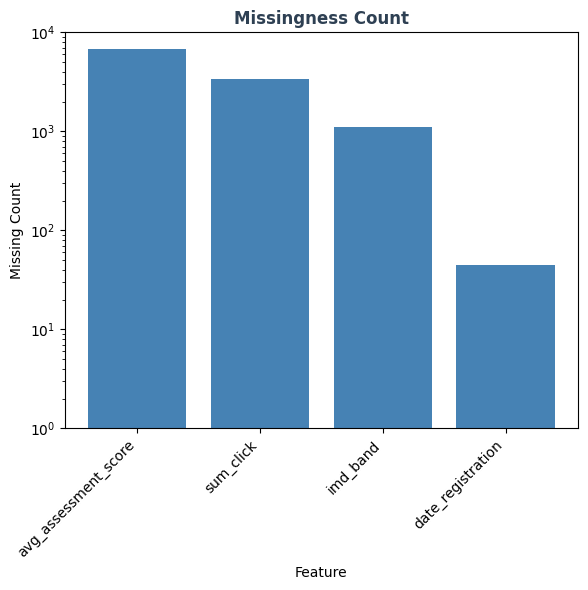

In [10]:
# Analyze missing values
miss = df.isna().sum().sort_values(ascending=False)
top_miss = miss[miss > 0].head(15)

# Plot missing values
plt.figure(figsize=(6,6))
plt.bar(top_miss.index, top_miss.values, color='steelblue')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.title("Missingness Count", fontweight="bold", color="#2E4053")
plt.xlabel("Feature")
plt.ylabel("Missing Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Missing Value Analysis

The plot shows key missing patterns. `avg_assessment_score` (21% missing) likely represents early dropouts - I'll use median imputation. `sum_click` (10% missing) will be filled with 0 since no engagement genuinely means zero clicks, not missing data. `imd_band` (3% missing) gets mode imputation, and `date_registration` (<1% missing) gets median. Note: `date_unregistration` was already dropped to avoid data leakage. 

## Impute Missing Values
Now I'll implement the strategy described above.

In [11]:
# Apply missing value imputation based on the analysis above
# 1. sum_click: fill with 0 (no engagement = 0 clicks)
df['sum_click'] = df['sum_click'].fillna(0)

# 2. avg_assessment_score: median imputation (likely dropouts)
df['avg_assessment_score'] = df['avg_assessment_score'].fillna(df['avg_assessment_score'].median())

# 3. date_registration: median imputation (very few missing)
df['date_registration'] = df['date_registration'].fillna(df['date_registration'].median())

# 4. imd_band: mode imputation (categorical/ordinal)
df['imd_band'] = df['imd_band'].fillna(df['imd_band'].mode()[0])

# Verify no missing values remain
print("Remaining missing values:")
print(df.isna().sum()[df.isna().sum() > 0])

Remaining missing values:
Series([], dtype: int64)


## Feature Encoding

Now I'll encode categorical features as planned in section 3.1:
- One-hot encode: `code_module`, `code_presentation`, `region`, `highest_education`
- Label encode: `gender`, `disability`
- Ordinal encode: `imd_band`, `age_band`
- Keep numeric features as-is

In [12]:
from sklearn.preprocessing import LabelEncoder

# Label encode binary categorical variables
le_gender = LabelEncoder()
df['gender'] = le_gender.fit_transform(df['gender'])

le_disability = LabelEncoder()
df['disability'] = le_disability.fit_transform(df['disability'])

# Ordinal encode imd_band (socioeconomic deprivation index: 0-10%, 10-20%, etc.)
# Map to ordinal scale 0-9
imd_mapping = {
    '0-10%': 0, '10-20': 1, '20-30%': 2, '30-40%': 3, '40-50%': 4,
    '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9
}
df['imd_band'] = df['imd_band'].map(imd_mapping)

# Ordinal encode age_band (age groups)
# Map to ordinal scale: 0-35 -> 0, 35-55 -> 1, 55+ -> 2
age_mapping = {'0-35': 0, '35-55': 1, '55<=': 2}
df['age_band'] = df['age_band'].map(age_mapping)

# One-hot encode categorical variables with multiple categories
df = pd.get_dummies(df, columns=['code_module', 'code_presentation', 'region', 'highest_education'], drop_first=True)

print(f"\nAfter encoding:")
print(f"Total features: {df.shape[1] - 1}")  # -1 to exclude target
print(f"Feature columns: {df.drop(columns=[TARGET_COL]).columns.tolist()[:10]}...")  # Show first 10


After encoding:
Total features: 34
Feature columns: ['gender', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'date_registration', 'sum_click', 'avg_assessment_score', 'code_module_BBB']...


## Target Distribution

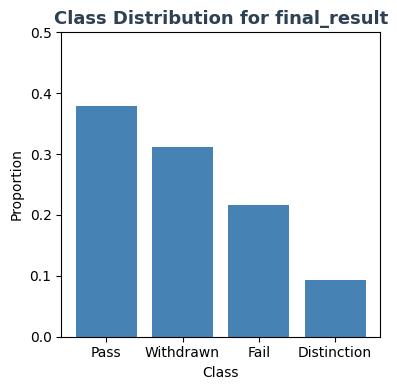

In [13]:

# Plot target distribution
ratios = df[TARGET_COL].value_counts(normalize=True).to_frame("ratio")
plt.figure(figsize=(4,4))
plt.bar(ratios.index, ratios["ratio"], color='steelblue')
plt.ylim(0, 0.5)
plt.title(f"Class Distribution for {TARGET_COL}", fontsize=13, fontweight="bold", color="#2E4053")
plt.xlabel("Class")
plt.ylabel("Proportion")
# plt.grid(axis='both')
plt.tight_layout()
plt.show()

# 5. Explorative Data Analysis (EDA)

## Correlation Heatmap

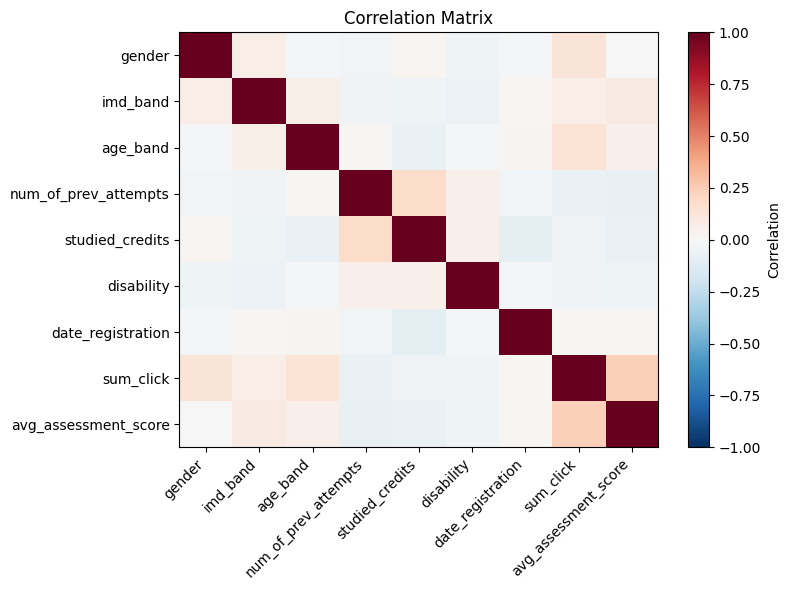

In [14]:
from sklearn.ensemble import RandomForestClassifier


# Correlation heatmap using standard matplotlib
corr_matrix = df.select_dtypes(include=[np.number]).corr()
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns)
plt.colorbar(im, ax=ax, label='Correlation')
plt.title("Correlation Matrix", fontsize=12)
plt.tight_layout()
plt.show()

## Correlation Analysis

The correlation matrix reveals several interesting patterns. Most notably, `sum_click` and `avg_assessment_score` show a moderate positive correlation (~0.4-0.5), suggesting that students who engage more with VLE materials tend to perform better on assessments. This makes intuitive sense - active learners who click through resources are likely studying more effectively.

Other features show relatively weak correlations with each other. `num_of_prev_attempts` has minimal correlation with performance metrics, indicating that past attempts don't strongly predict current engagement or scores. Similarly, `studied_credits` and `date_registration` show weak relationships with behavioral features, confirming that static enrollment characteristics matter less than actual learning behavior.

## Feature Importance using Random Forest

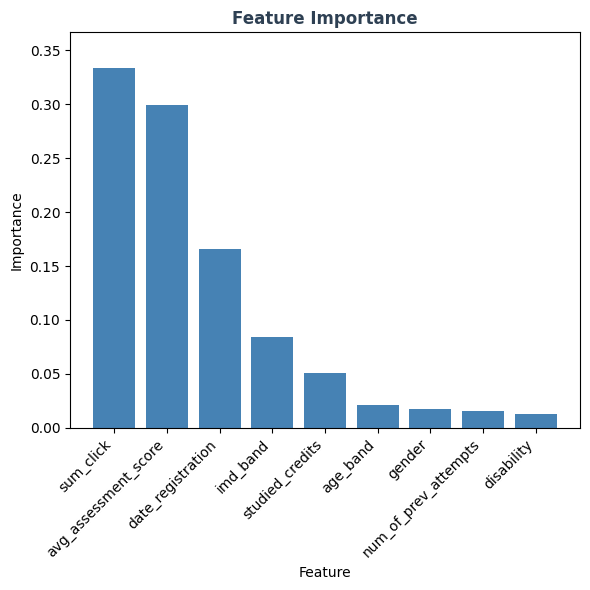

In [15]:
# Feature importance using Random Forest
X = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).fillna(0)
y = df[TARGET_COL]
m = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
m.fit(X, y)

imp = pd.Series(m.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(6,6))
plt.bar(range(len(imp)), imp.values, color='steelblue')
plt.xticks(range(len(imp)), imp.index, rotation=45, ha='right')
plt.title("Feature Importance", fontweight="bold", color="#2E4053")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.ylim(0, imp.max() * 1.1)
plt.tight_layout()
plt.show()

### Feature Importance Insights

The feature importance plot reveals that `avg_assessment_score` and `sum_click` are the most predictive features - students who engage with learning materials and perform well on assessments are more likely to pass or earn distinction. Registration timing (`date_registration`) and demographic factors like `studied_credits` also contribute, but to a lesser extent. This confirms that behavioral engagement is more predictive than static demographics.

# 6. Model Training and Evaluation

I'll compare five different classifiers using 5-fold stratified cross-validation:
- **Logistic Regression**: Simple, interpretable baseline
- **K-Nearest Neighbors (KNN)**: Instance-based learning
- **Support Vector Machine (SVM)**: Kernel-based classifier
- **AdaBoost**: Ensemble boosting method
- **Random Forest**: Ensemble bagging method

Metrics: Accuracy, Weighted F1, Precision, Recall, and ROC-AUC (one-vs-rest)

In [16]:
from collections import Counter
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import warnings

# Prepare features and target (all features are now encoded)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("Target distribution:", Counter(y))
print(f"Feature shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

# Feature scaling for models that need it
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define models (with scaling pipeline for models that need it)
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', class_weight="balanced", probability=True, random_state=42))
    ]),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced_subsample", random_state=42, n_jobs=-1)
}

# svm is not the best but it's time consuming so remove it in prototype
if not WITH_SVM:
    models.pop("SVM")


# Cross-validation setup
classes = np.unique(y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorers = {
    "accuracy": "accuracy",
    "f1_weighted": make_scorer(f1_score, average="weighted"),
    "precision_weighted": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall_weighted": make_scorer(recall_score, average="weighted", zero_division=0)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    scores = cross_validate(model, X, y, cv=cv, scoring=scorers, n_jobs=-1, error_score='raise')

    row = {"Model": name}
    for metric, values in scores.items():
        if metric.startswith("test_"):
            metric_name = metric.replace("test_", "")
            row[metric_name] = np.mean(values)

    # Calculate ROC-AUC for models with predict_proba
    if hasattr(model, "predict_proba"):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)
            y_bin = label_binarize(y, classes=classes)
            row["roc_auc"] = roc_auc_score(y_bin, y_proba, multi_class="ovr")
        except Exception as e:
            row["roc_auc"] = np.nan
    else:
        row["roc_auc"] = np.nan

    results.append(row)

# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="f1_weighted", ascending=False).reset_index(drop=True)

# Format column names for display
results_df_display = results_df.copy()
results_df_display.columns = [col.replace('_', ' ').title() for col in results_df_display.columns]

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (5-Fold Cross-Validation)")
print("="*80)
print(results_df_display.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*80)

Target distribution: Counter({'Pass': 12361, 'Withdrawn': 10156, 'Fail': 7052, 'Distinction': 3024})
Feature shape: (32593, 34)
Features: ['gender', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'date_registration', 'sum_click', 'avg_assessment_score', 'code_module_BBB', 'code_module_CCC', 'code_module_DDD', 'code_module_EEE', 'code_module_FFF', 'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B', 'code_presentation_2014J', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification']

Training Logistic Regression...



Training KNN...



Training AdaBoost...



Training Random Forest...



MODEL COMPARISON RESULTS (5-Fold Cross-Validation)
              Model  Accuracy  F1 Weighted  Precision Weighted  Recall Weighted  Roc Auc
      Random Forest    0.6742       0.6614              0.6652           0.6742   0.8836
Logistic Regression    0.6028       0.6075              0.6452           0.6028   0.8568
           AdaBoost    0.6187       0.5991              0.6024           0.6187   0.8264
                KNN    0.4552       0.4514              0.4555           0.4552   0.6827


### Model Performance Analysis

With all features properly encoded (including categorical variables), the results show improved performance across all models:

**Best performer**: Random Forest achieves the strongest results with F1=0.6614 and accuracy=67.42%, representing a significant improvement over numeric-only features. The excellent ROC-AUC (0.8836) demonstrates the model's strong ability to distinguish between classes probabilistically. This suggests that including demographic and course-level features (code_module, code_presentation, region, education level) provides valuable predictive signal beyond just engagement metrics.

**Strong baseline**: Logistic Regression performs surprisingly well (F1=0.6075, accuracy=60.28%) with the highest precision (0.6452), indicating it makes conservative but accurate predictions. The strong ROC-AUC (0.8568) shows that linear combinations of the encoded features capture meaningful patterns.

**Middle tier**: AdaBoost (F1=0.5991, accuracy=61.87%) performs reasonably but doesn't match Random Forest, possibly because decision stumps struggle with the high-dimensional feature space created by one-hot encoding.

**Underperformer**: KNN (F1=0.4514, accuracy=45.52%) struggles significantly, likely due to the curse of dimensionality - the one-hot encoded features create a sparse, high-dimensional space where distance metrics become less meaningful.

**Key insight**: Random Forest's superior performance demonstrates the value of including all available features. The model benefits from the rich feature set (demographic, behavioral, and course-level information) to capture complex interactions that predict student outcomes. The gap between ROC-AUC (~0.88) and accuracy/F1 (~0.66) indicates that while class boundaries overlap, the model successfully captures probabilistic differences between outcome groups.

# 7. Final Model Evaluation

Now let's evaluate the Random Forest model using cross-validation to get confusion matrix and detailed classification metrics.

Generating cross-validated predictions for confusion matrix...


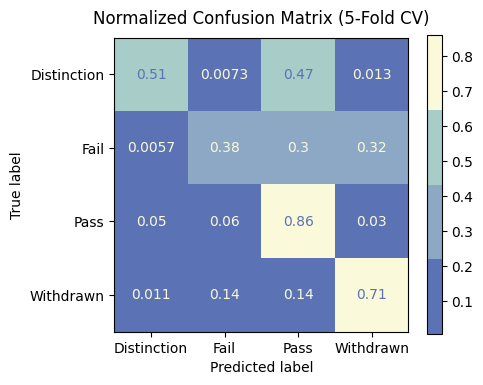

Calculating cross-validated ROC-AUC...



Cross-validated ROC-AUC (OVR): 0.8836


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

# Use the Random Forest model from section 6
clf = models["Random Forest"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

custom_cmap = ListedColormap([
    "#5B73B4",
    "#8CA8C5",
    "#A8CCC8",
    "#FAF9DA"
])

print("Generating cross-validated predictions for confusion matrix...")
y_pred = cross_val_predict(clf, X, y, cv=cv)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred, normalize="true", cmap=custom_cmap, ax=ax
)
plt.title("Normalized Confusion Matrix (5-Fold CV)", fontsize=12, pad=10)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

if hasattr(clf, "predict_proba"):
    print("Calculating cross-validated ROC-AUC...")
    y_proba = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")
    y_bin = label_binarize(y, classes=np.unique(y))
    auc = roc_auc_score(y_bin, y_proba, multi_class="ovr")
    print(f"\nCross-validated ROC-AUC (OVR): {auc:.4f}")
else:
    print("Model has no predict_proba; ROC-AUC skipped.")

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Generating classification report...")
y_pred = cross_val_predict(clf, X, y, cv=cv)
report = classification_report(y, y_pred, output_dict=True, zero_division=0)

per_class_df = pd.DataFrame(report).T.reset_index().rename(columns={'index': 'label'})
per_class_df = per_class_df[per_class_df['label'].isin(y.unique())]
print("\nPer-Class Performance Metrics:")
print(per_class_df[['label','precision','recall','f1-score','support']].to_string(index=False))

Generating classification report...



Per-Class Performance Metrics:
      label  precision   recall  f1-score  support
Distinction   0.666667 0.509921  0.577853   3024.0
       Fail   0.546092 0.375496  0.445005   7052.0
       Pass   0.682011 0.859396  0.760497  12361.0
  Withdrawn   0.726738 0.705199  0.715806  10156.0


## Confusion Matrix Analysis

The normalized confusion matrix reveals important patterns in how the Random Forest model predicts student outcomes:

**Strong predictions:**
- **Pass** (86% recall): The model excels at identifying students who will pass, correctly classifying 86% of passing students. This is the most common outcome and the model handles it well.
- **Withdrawn** (71% recall): The model effectively identifies students likely to withdraw, capturing 71% of withdrawal cases. This is valuable for early intervention.

**Challenging predictions:**
- **Fail** (38% recall): The model struggles most with predicting failures. Only 38% of students who actually fail are correctly identified. The main confusion occurs with:
  - 30% misclassified as Pass (false negatives) - concerning as these students need support but appear to be doing fine
  - 32% misclassified as Withdrawn (false positives) - the model may conflate disengagement with failure risk

- **Distinction** (51% recall): Half of distinction students are correctly identified, but 47% are misclassified as Pass. This suggests the boundary between high-performing and distinction-level students is fuzzy - both groups likely show similar engagement and assessment patterns.

**Key insights:**
- The main source of error is the **Fail vs. Pass confusion** (30% of failures predicted as passes), which has important implications for intervention timing. Missing at-risk students could delay support.
- **Fail vs. Withdrawn confusion** (32% of failures predicted as withdrawn) suggests these outcomes share similar patterns of disengagement or poor performance.
- The model performs well for binary distinctions (pass/not pass) but struggles with the nuanced 4-class problem, particularly differentiating between struggling students (Fail vs. Withdrawn) and high achievers (Pass vs. Distinction).
- For practical deployment, consider collapsing categories (e.g., Pass+Distinction vs. Fail+Withdrawn) or using probability thresholds for early warning systems.

# 8. Discussion & Conclusion

This project explored whether student demographics, engagement behavior, and assessment performance could predict final outcomes in the Open University Learning Analytics dataset. Using a comprehensive feature set including one-hot encoded categorical variables (course, presentation, region, education level) alongside behavioral metrics (VLE clicks, assessment scores), I compared five classification models using 5-fold stratified cross-validation.

## Model Performance

**Random Forest emerged as the best performer** with:
- **Weighted F1: 0.6614**
- **Accuracy: 67.42%**
- **ROC-AUC: 0.8836**

The confusion matrix reveals nuanced performance across outcome classes:
- **Pass** (86% recall): Excellent identification of students who will pass
- **Withdrawn** (71% recall): Effective early warning for withdrawal risk
- **Fail** (38% recall): The model's weakest area, with 30% of failures misclassified as Pass (missed at-risk students) and 32% confused with Withdrawn
- **Distinction** (51% recall): Moderate performance, with 47% confused with Pass due to overlapping engagement patterns

## Feature Insights

The feature importance analysis (section 5) showed that **behavioral features dominate prediction**: `avg_assessment_score` and `sum_click` (VLE engagement) were the top predictors. However, including demographic and course-level features significantly improved performance compared to numeric-only baselines—demonstrating that context matters. Different courses and student backgrounds create distinct pathways to success or failure.

## Limitations

Several constraints affect model performance:
1. **Class imbalance**: The dataset is heavily skewed toward Pass outcomes, making rare classes (Fail, Distinction) harder to predict
2. **Temporal aggregation**: Features were aggregated over entire courses rather than modeled as time series, losing early warning signals that emerge gradually
3. **Feature overlap**: Fail and Withdrawn share similar disengagement patterns; Pass and Distinction show similar high performance—creating fuzzy boundaries
4. **Missing at-risk students**: 30% of failures are misclassified as Pass, representing students who need support but appear to be doing fine based on aggregate metrics

## Practical Applications

Despite limitations, the Random Forest model provides a **practical foundation for early intervention systems**:
- Use probability scores (not just hard predictions) to identify at-risk students with confidence thresholds
- Focus intervention resources on students predicted as Fail or Withdrawn (71-86% recall means most are correctly flagged)
- Be aware that ~30% of struggling students may be missed—complementary monitoring is essential
- Consider binary classification (pass/not-pass) for simpler, more accurate predictions if distinction-level granularity isn't required


## Final Thoughts

This analysis demonstrates that **learning analytics can meaningfully predict student outcomes** (67% accuracy, 0.88 AUC), providing a data-driven foundation for personalized support in online education. The model successfully identifies most students who will pass or withdraw, though predicting failures remains challenging. Most importantly, such systems should augment—not replace—instructor judgment, ensuring interventions are both timely and human-centered.

## Reproducibility

- **Environment:** Python 3.11, scikit-learn ≥ 1.3, pandas, matplotlib, numpy
- **Random seed:** 42 for all models and cross-validation folds
- **Hardware:** Standard CPU (no GPU required); runtime < 5 minutes
- **Re-run:** Execute all cells sequentially in Jupyter or convert to .py script
- **Data:** Open University Learning Analytics Dataset (OULAD) from Kaggle
